In [194]:
import numpy as np
import pandas as pd
from scipy.stats import norm, laplace, cauchy, multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(8)

In [195]:
import wesanderson as wes

sns.set_palette(sns.color_palette(wes.film_palette('Darjeeling Limited')))

# Utility Functions


In [196]:
def traceplot(samples, w=6, h=4, overlay=True, n_col=2):
    # samples: (#components, #iterations)
    
    n_component = samples.shape[0]
    n_iter = samples.shape[1]

    if overlay:
        fig, ax = plt.subplots(figsize=(6,4))
        
        for i in range(n_component):
            sns.lineplot(x=range(1, n_iter+1), y=samples[i, :], label=rf'$X_{i+1}$', linewidth=0.5, legend=False)

        # Set labels
        ax.set_xlabel('t')
        ax.set_ylabel(r'$X_i(t)$')

        # Create figure-level legend outside the plot
        fig.legend(loc='upper left', bbox_to_anchor=(0.9, 0.9), frameon=False)

        # Modify the line width in the legend
        legend = fig.legends[0]
        for line in legend.get_lines():
            line.set_linewidth(1)
        
        plt.show()
    else:
        n_row = np.ceil(n_component / n_col).astype(int)

        fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(w*n_col, h*n_row))

        for i in range(n_component):
            ax = axes.flat[i]
            
            sns.lineplot(x=range(1, n_iter+1), y=samples[i, :], ax=ax, linewidth=0.5)
            
            # Set labels
            ax.set_xlabel('t')
            ax.set_ylabel(fr'$X_{i+1}(t)$')

        # Delete any unused axes (if there are fewer features than subplot slots)
        for i in range(n_component, len(axes.flat)):
            fig.delaxes(axes.flat[i])

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()                     

# Log Distributions


In [197]:
def logpi_normal(x, location=0, scale=1):
    return np.sum(norm.logpdf(x, loc=location, scale=scale))

def logpi_laplace(x, location=0, scale=1):
    return np.sum(laplace.logpdf(x, loc=location, scale=scale))

def logpi_cauchy(x, location=0, scale=1):
    return np.sum(cauchy.logpdf(x, loc=location, scale=scale))

def logpi_mvnormal(x, location=0, covariance=1):
    return np.sum(multivariate_normal.logpdf(x, mean=location, cov=covariance))

In [198]:
def grad_logpi_normal(x, location=0, scale=1):
    return  -(x - location) /scale**2


def grad_logpi_laplace(x, location=0, scale=1):
    return -np.sign(x - location) / scale


def grad_logpi_cauchy(x, location=0, scale=1):
    return -2*(x - location) / (scale**2 + (x - location)**2)


def grad_logpi_mvnormal(x, location=0, covariance=1):
    # Univariate case
    if np.isscalar(covariance):
        sigma_inv = 1 / covariance
        gradient = -sigma_inv * (x - location)
    
    # Multivariate cas:
    else:
        covariance = np.asarray(covariance).squeeze()
        
        if covariance.ndim == 1:
            sigma_inv = np.linalg.inv(np.diag(covariance))
        else:
            sigma_inv = np.linalg.inv(covariance)

        gradient = -np.matmul(sigma_inv, (x - location))

    return gradient

# MCMC Algorithms


## Random Walk Metropolis


In [199]:
def random_walk_proposal(x, step_size):
    return x + step_size * np.random.normal(size=len(x))


def random_walk(logpi, n_iter, x_init, step_size=1, **kwargs):
    # Matrix to store the sampled values from the chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of the target distribution at the current state
    x = x_init
    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        # Propose a candidate move
        y = random_walk_proposal(x, step_size)
        logpi_y = logpi(y, **kwargs)

        # Calculate the difference in the log-probabilities of the proposed and
        # current states (i.e. \log \frac{\pi(y)}{\pi(x)})
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update the current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store the current state
        x_samples[:, i] = x

    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

### RWM Experiment


Acceptance rate:0.716


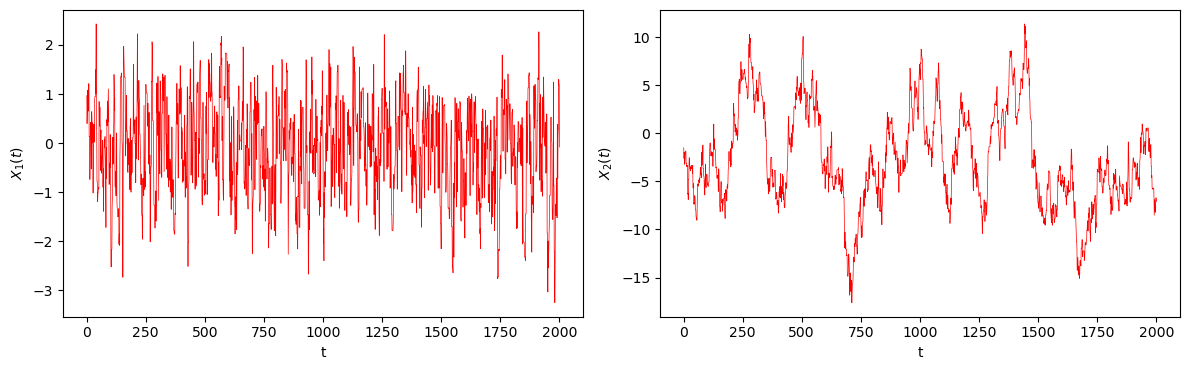

In [223]:
samples, accept_rate = random_walk(
    logpi=logpi_mvnormal, 
    n_iter=2000, 
    x_init=np.array([0, 0]), 
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]]
 )

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)

# quantiles = pd.DataFrame(columns=['0.25', '0.5', '0.75'])
# quantiles.loc['actual'] = cauchy.ppf([0.25, 0.5, 0.75], loc=0, scale=1)

# for i in range(0, samples.shape[0]):
#     quantiles.loc[f'X{i+1}'] = np.quantile(samples[i, :], [0.25, 0.5, 0.75])

# quantiles

## Barker Metropolis-Hastings


In [ ]:
def barker_proposal(x, grad_logpi_x, step_size=1):
    # Magnitude
    z = np.random.normal(size=len(x), scale=1) * step_size

    # Direction
    threshold = 1 / (1 + np.exp(- grad_logpi_x * z))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + b * z


def barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y):
    logq_xy = - np.log1p(np.exp(- grad_logpi_x * (y - x)))
    logq_yx = - np.log1p(np.exp(- grad_logpi_y * (x - y)))

    return np.sum(logq_yx - logq_xy)
   

def barker(logpi, grad_logpi, n_iter, x_init, step_size=1, **kwargs):
    # Matrix to store the sampled values from the chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of the target distribution at the current state
    x = np.array(x_init)
    logpi_x = logpi(x, **kwargs)
    
    for i in range(n_iter):
        grad_logpi_x = grad_logpi(x, **kwargs)

        # Propose a candidate move
        y = barker_proposal(x, grad_logpi_x, step_size)
        logpi_y = logpi(y, **kwargs)
        grad_logpi_y = grad_logpi(y, **kwargs)

        # Calculate the Barker acceptance rate
        logq_ratio = barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y)
        log_acceptance = logpi_y - logpi_x + logq_ratio
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update the current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted +=1

        # Store the current state
        x_samples[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate 

### Barker Experiment


Acceptance rate:0.9105


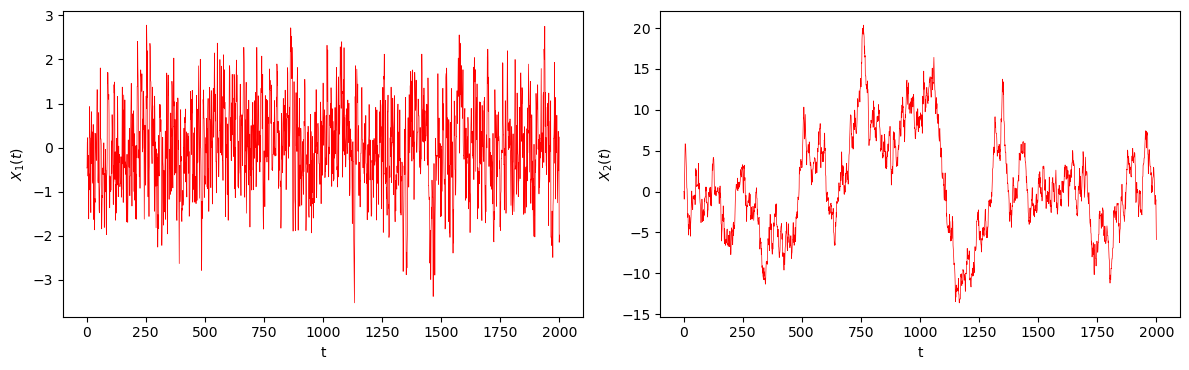

In [222]:
samples, accept_rate = barker(
    logpi=logpi_mvnormal, 
    grad_logpi=grad_logpi_mvnormal, 
    n_iter=2000, 
    x_init=np.array([0, 0]), 
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]]
)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)

# quantiles = pd.DataFrame(columns=['0.25', '0.5', '0.75'])
# quantiles.loc['actual'] = cauchy.ppf([0.25, 0.5, 0.75], loc=0, scale=1)

# for i in range(0, samples.shape[0]):
#     quantiles.loc[f'X{i+1}'] = np.quantile(samples[i, :], [0.25, 0.5, 0.75])

# quantiles

## Pre-conditioned Barker Metropolis-Hastings


In [206]:
def preconditioned_barker_proposal(x, grad_logpi_x, C, step_size=1):
    # Draw z independently for each component
    z = np.random.normal(size=len(x), scale=1) * step_size

    c = grad_logpi_x @ C.T
    threshold = 1 / (1 + np.exp(- z * c))

    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 
    z *= b

    return x + C.T @ z


def preconditioned_barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, C):
    z = np.linalg.inv(C.T) @ (y - x)

    c_x = grad_logpi_x @ C.T
    c_y = grad_logpi_y @ C.T

    logq_xy = - np.log1p(np.exp(- z * c_x))
    logq_yx = - np.log1p(np.exp(z * c_y))

    return np.sum(logq_yx - logq_xy)


def preconditioned_barker(logpi, grad_logpi, n_iter, x_init, location, covariance, step_size=1):
    # Matrix to store the sampled values from the chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of the target distribution at the current state
    x = np.array(x_init)
    logpi_x = logpi(x, location, covariance)

    # Cholesky factor
    covariance = np.asarray(covariance)
    C = np.linalg.cholesky(covariance)
    
    for i in range(n_iter):
        grad_logpi_x = grad_logpi(x, location, covariance)

        # Propose a candidate move
        y = preconditioned_barker_proposal(x, grad_logpi_x, C, step_size)
        logpi_y = logpi(y, location, covariance)
        grad_logpi_y = grad_logpi(y, location, covariance)

        # Calculate the preconditioned Barker acceptance rate
        logq_ratio = preconditioned_barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, C)
        log_acceptance = logpi_y - logpi_x + logq_ratio
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update the current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted +=1

        # Store the current state
        x_samples[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate 

### Pre-conditioned Barker Experiment


Acceptance rate:0.782


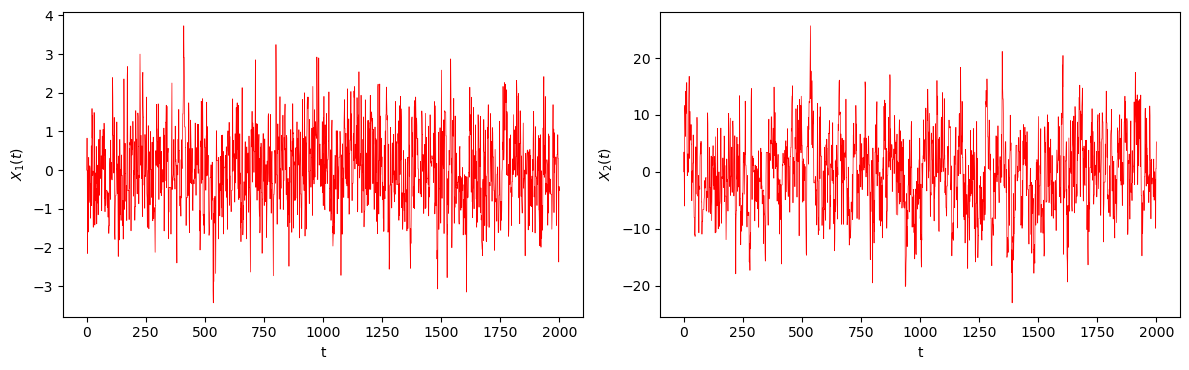

In [221]:
samples, accept_rate = preconditioned_barker(
    logpi=logpi_mvnormal, 
    grad_logpi=grad_logpi_mvnormal, 
    n_iter=2000, 
    x_init=np.array([0, 0]),
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]]
)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)

## Metropolis-Adjusted Langevin Algorithm


In [202]:
def mala_proposal(x, grad_logpi_x, step_size):
    noise = step_size * np.random.normal(size=len(x))
    return x + (1/2) * (step_size**2) * grad_logpi_x + noise


def mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, step_size):
    log_xy = multivariate_normal.logpdf(y, mean=(x + (1/2) * (step_size**2) * grad_logpi_x), cov=(step_size**2))
    log_yx = multivariate_normal.logpdf(x, mean=(y + (1/2) * (step_size**2) * grad_logpi_y), cov=(step_size**2))
    
    return log_yx - log_xy


def mala(logpi, grad_logpi, n_iter, x_init, step_size=1, **kwargs):
    # Matrix to store the sampled values from the chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of the target distribution at the current state
    x = x_init
    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        grad_logpi_x = grad_logpi(x, **kwargs)
        
        # Propose a candidate move
        y = mala_proposal(x, grad_logpi_x, step_size)
        logpi_y = logpi(y, **kwargs)
        grad_logpi_y = grad_logpi(y, **kwargs)

        # Calculate the MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + mala_logq_ratio(x, y, grad_logpi_x, grad_logpi_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update the current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store the current state
        x_samples[:, i] = x
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

### MALA Experiments


Acceptance rate:0.9175


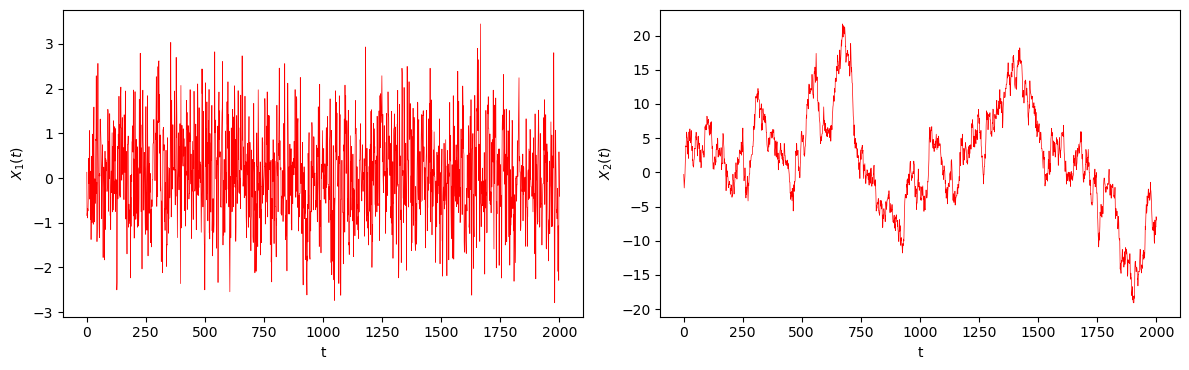

In [220]:
samples, accept_rate = mala(
    logpi=logpi_mvnormal, 
    grad_logpi=grad_logpi_mvnormal, 
    n_iter=2000, 
    x_init=np.array([0, 0]), 
    location=[0, 0], 
    covariance=[[1, 0.8], [0.8, 50]]
)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples, overlay=False)

# quantiles = pd.DataFrame(columns=['0.25', '0.5', '0.75'])
# quantiles.loc['actual'] = cauchy.ppf([0.25, 0.5, 0.75], loc=0, scale=1)

# for i in range(0, samples.shape[0]):
#     quantiles.loc[f'X{i+1}'] = np.quantile(samples[i, :], [0.25, 0.5, 0.75])

# quantiles